## SCOTCH Example Workflow

This notebook is a tutorial for SCOTCH (*S*ingle *C*ell *O*rthogonal matrix *T*ri-factorzation for *C*lustering *H*igh-dimensional data). SCOTCH uses non-negative matrix tri-factorization to cluster cells and define gene sets which drive each cell clusters expression profile. 

In [1]:
import SCOTCH
import pandas as pd 
import numpy as np 
import anndata as ad
import scanpy as sc
import pooch

import torch

import matplotlib.pyplot as plt
import matplotlib.gridspec as GridSpec

### Loading single cell data 

SCOTCH allows loading through three interfaces, plain text files, anndata objects, or pytorch pt. files. For this example we will work with the exampledata scat is used for the scverse and scanpy tutorials. The data that are using is the 2021 NeurIPS benchmarking dataset. The samples used in this data were measured with the 10X multiome gene expression and chromatin accessibility kit. We will focus on the filtered expression matrices. That data contains ~16,000 from two different donors and span 36,601 genes. 

For this tutorial we utilize the beginning of the guide for scanpy which downloads the data into a standard adata object (adata). 

In [2]:
EXAMPLE_DATA = pooch.create(
    path=pooch.os_cache("scverse_tutorials"),
    base_url="doi:10.6084/m9.figshare.22716739.v1/",
)
EXAMPLE_DATA.load_registry_from_doi()

In [3]:
samples = {
    "s1d1": "s1d1_filtered_feature_bc_matrix.h5",
    "s1d3": "s1d3_filtered_feature_bc_matrix.h5",
}
adatas = {}

for sample_id, filename in samples.items():
    path = EXAMPLE_DATA.fetch(filename)
    sample_adata = sc.read_10x_h5(path)
    sample_adata.var_names_make_unique()
    adatas[sample_id] = sample_adata

adata = ad.concat(adatas, label="sample")
adata.obs_names_make_unique()
print(adata.obs["sample"].value_counts())

/mnt/dv/wid/projects5/Roy-singlecell/spencer_work/.conda/envs/Pytorch_2_5/lib/python3.13/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/mnt/dv/wid/projects5/Roy-singlecell/spencer_work/.conda/envs/Pytorch_2_5/lib/python3.13/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


sample
s1d1    8785
s1d3    8340
Name: count, dtype: int64


/mnt/dv/wid/projects5/Roy-singlecell/spencer_work/.conda/envs/Pytorch_2_5/lib/python3.13/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/mnt/dv/wid/projects5/Roy-singlecell/spencer_work/.conda/envs/Pytorch_2_5/lib/python3.13/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/mnt/dv/wid/projects5/Roy-singlecell/spencer_work/.conda/envs/Pytorch_2_5/lib/python3.13/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


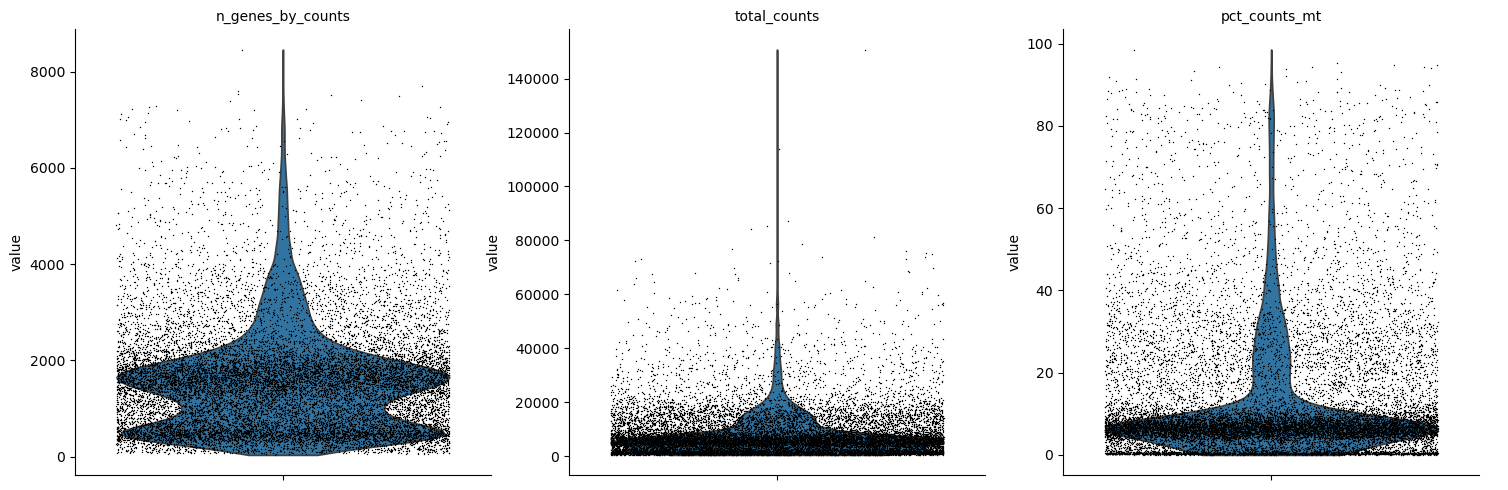

In [4]:
# mitochondrial genes, "MT-" for human, "Mt-" for mouse
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes
adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True
)

sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

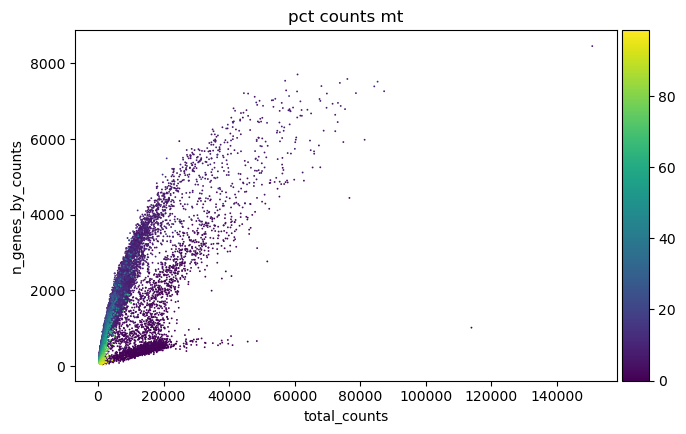

In [5]:
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [6]:
sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_genes(adata, min_cells=3)
#sc.pp.scrublet(adata, batch_key="sample")

In [7]:
adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_total(adata)
# Logarithmize the data
sc.pp.log1p(adata)

In [8]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000, batch_key="sample")
adata_high_var= adata[:, adata.var["highly_variable"]]

### Initializing a SCOTCH object

Now we can initialize SCOTCH. SCOTCH is a matrix tri factorization approach that estimates the data as multiplication of three matrices. 

$X \approx U S V^{T}$ where $U$ is a near orthogonal matrix which is used to cluster the cell space, $V$ is a near orthogonal matrix which is used to cluster the gene space, and $S$ is relationsip matrix which relates gene and cell clusters. 

To start SCOTCH we need to initialize a SCOTCH object, and specify the number of cluster we want to use for the cell space (k1), and the number of cluster for the gene space (k2). We can also specify regularization parameters such as $\lambda_u$ or $\lambda_v$ which can be tuned to improve the orthogonality of the cell and gene clusters respectively. 


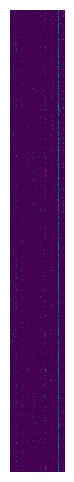

In [9]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot()
X_dense = adata_high_var.X.toarray() if hasattr(adata_high_var.X, 'toarray') else adata_high_var.X
ax.imshow(X_dense, interpolation="nearest", cmap = 'viridis')
ax.set_axis_off()

In [10]:
scotch = SCOTCH.SCOTCH(k1 = 15, k2 = 30, max_l_u = 0.10, max_l_v = 0.10, term_tol = 1e-10, var_lambda= False, device = "cuda:0", init_style= "random", verbose = True)
scotch.addDataFromAData(adata_high_var)
scotch.send_to_gpu()


In [11]:
scotch.fit()

Initializing NMTF factors
Beginning NMTF
Iter: 1	Iter Time: 2.461	Total Time: 2.461	Error: 2.730e+06	Relative Delta Residual: 3.456e-01
Iter: 2	Iter Time: 1.099	Total Time: 3.560	Error: 2.359e+06	Relative Delta Residual: 1.356e-01
Iter: 3	Iter Time: 1.100	Total Time: 4.661	Error: 2.305e+06	Relative Delta Residual: 2.289e-02
Iter: 4	Iter Time: 1.099	Total Time: 5.759	Error: 2.223e+06	Relative Delta Residual: 3.577e-02
Iter: 5	Iter Time: 1.099	Total Time: 6.858	Error: 2.102e+06	Relative Delta Residual: 5.428e-02
Iter: 6	Iter Time: 1.100	Total Time: 7.958	Error: 1.866e+06	Relative Delta Residual: 1.125e-01
Iter: 7	Iter Time: 1.099	Total Time: 9.057	Error: 1.640e+06	Relative Delta Residual: 1.210e-01
Iter: 8	Iter Time: 1.099	Total Time: 10.156	Error: 1.550e+06	Relative Delta Residual: 5.472e-02
Iter: 9	Iter Time: 1.099	Total Time: 11.255	Error: 1.518e+06	Relative Delta Residual: 2.094e-02
Iter: 10	Iter Time: 1.099	Total Time: 12.354	Error: 1.501e+06	Relative Delta Residual: 1.078e-02
Iter:

In [12]:
scotch.send_to_cpu()
scotch.assign_cluster()
adata_high_var = scotch.addScotchEmbeddingsToAnnData(adata_high_var)

/mnt/dv/wid/projects5/Roy-singlecell/spencer_work/atac_rna_int/pyNMTF/SCOTCH.py:134: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['cell_clusters'] = pd.Categorical(self.U_assign.detach().numpy())


In [13]:
adata_high_var

AnnData object with n_obs × n_vars = 17041 × 2000
    obs: 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes', 'cell_clusters'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'gene_clusters'
    uns: 'log1p', 'hvg', 'S_matrix'
    obsm: 'cell_embedding', 'P_embedding'
    varm: 'gene_embedding', 'Q_embedding'
    layers: 'counts'

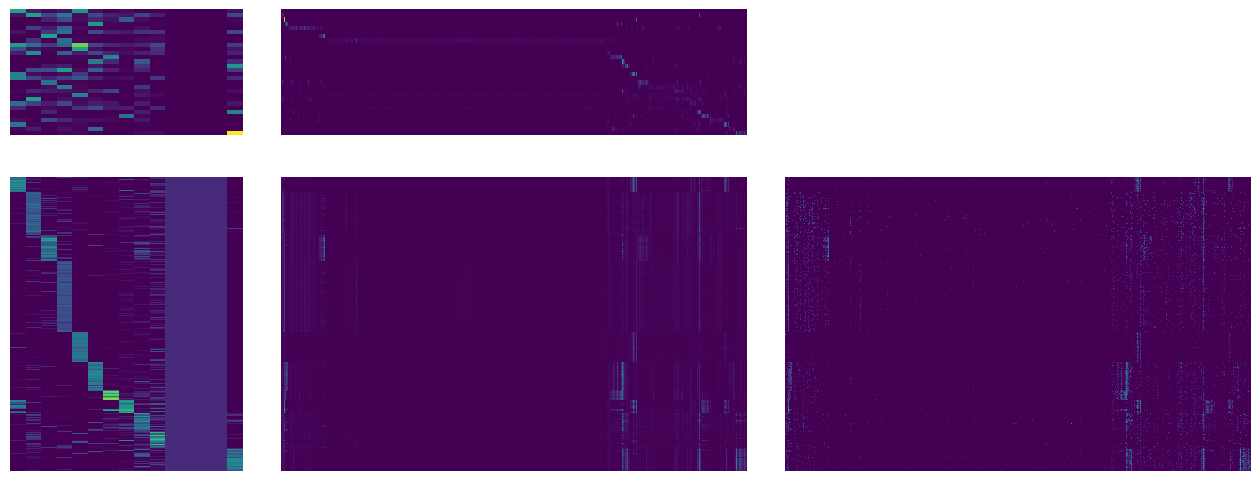

In [14]:
scotch.visualizeFactorsSorted()

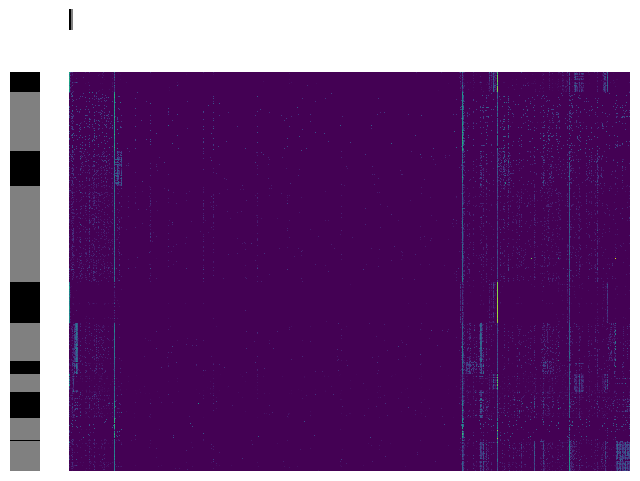

In [15]:
scotch.visualizeClustersSorted()

In [16]:
sc.pp.pca(adata_high_var) 

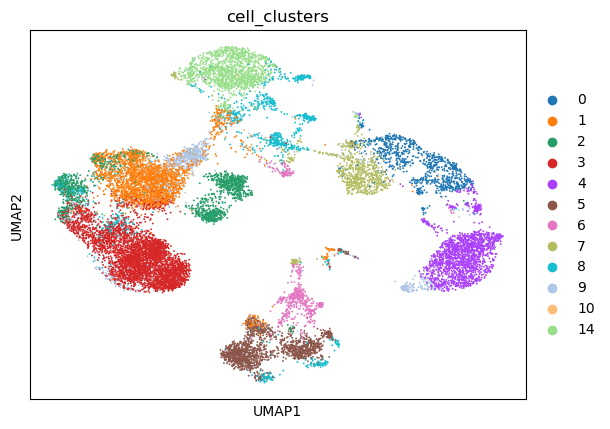

In [17]:
sc.pp.neighbors(adata_high_var, use_rep= "X_pca", metric = "cosine")
sc.tl.umap(adata_high_var)
sc.pl.umap(adata_high_var, color = "cell_clusters")

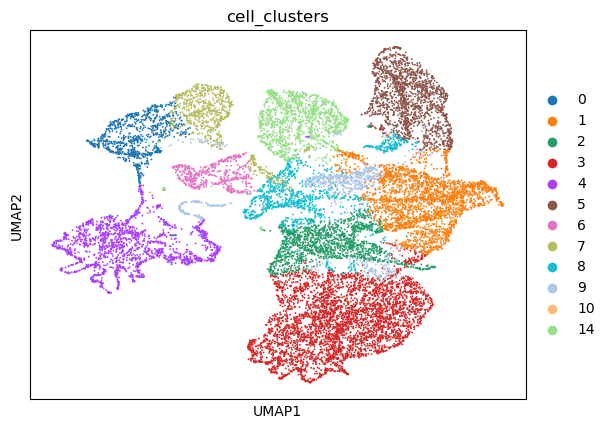

In [18]:
sc.pp.neighbors(adata_high_var, use_rep= "cell_embedding")
sc.tl.umap(adata_high_var)
sc.pl.umap(adata_high_var, color = "cell_clusters")

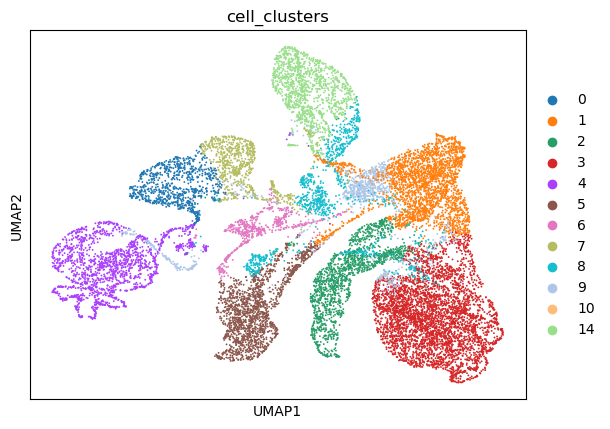

In [19]:
sc.pp.neighbors(adata_high_var, use_rep= "P_embedding")
sc.tl.umap(adata_high_var)
sc.pl.umap(adata_high_var, color = "cell_clusters")

In [ ]:
scotch.send_to_gpu()
scotch.reclusterV()

Iter: 1	Iter Time: 2.113	Total Time: 2.113	Error: 1.306e+06	Relative Delta Residual: 1.350e-03
Iter: 2	Iter Time: 1.097	Total Time: 3.210	Error: 1.298e+06	Relative Delta Residual: 5.579e-03
Iter: 3	Iter Time: 1.097	Total Time: 4.307	Error: 1.295e+06	Relative Delta Residual: 2.803e-03
Iter: 4	Iter Time: 1.097	Total Time: 5.404	Error: 1.294e+06	Relative Delta Residual: 5.871e-04
Iter: 5	Iter Time: 1.096	Total Time: 6.500	Error: 1.294e+06	Relative Delta Residual: -1.250e-04
Iter: 6	Iter Time: 1.097	Total Time: 7.597	Error: 1.295e+06	Relative Delta Residual: -4.124e-04
Iter: 7	Iter Time: 1.097	Total Time: 8.694	Error: 1.295e+06	Relative Delta Residual: -4.838e-04
Iter: 8	Iter Time: 1.097	Total Time: 9.790	Error: 1.296e+06	Relative Delta Residual: -5.163e-04
Iter: 9	Iter Time: 1.097	Total Time: 10.887	Error: 1.297e+06	Relative Delta Residual: -5.218e-04
Iter: 10	Iter Time: 1.097	Total Time: 11.985	Error: 1.297e+06	Relative Delta Residual: -4.913e-04
Iter: 11	Iter Time: 1.096	Total Time: 13.

In [ ]:
scotch.send_to_cpu()
scotch.assign_cluster()
scotch.visualizeClusters()
scotch.visualizeFactors()
scotch.visualizeFactorsSorted()

In [ ]:
adata_high_var = scotch.addScotchEmbeddingsToAnnData(adata_high_var)
sc.pp.neighbors(adata_high_var, use_rep= "X_pca")
sc.tl.umap(adata_high_var)
sc.pl.umap(adata_high_var, color = "cell_clusters")

In [ ]:
scotch_no_reg = SCOTCH.SCOTCH(k1 = 15, k2 = 30, max_l_u = 0.0, max_l_v = 0.0, term_tol = 1e-10, var_lambda= False, device = "cuda:0", init_style= "random", verbose = True)
scotch_no_reg.addDataFromAData(adata_high_var)
scotch_no_reg.send_to_gpu()


In [ ]:
scotch_no_reg.fit()

In [ ]:
scotch_no_reg.send_to_cpu()
scotch_no_reg.assign_cluster()
adata_high_var = scotch_no_reg.addScotchEmbeddingsToAnnData(adata_high_var)

In [ ]:
scotch_no_reg.visualizeClustersSorted()

In [ ]:
scotch_no_reg.visualizeFactorsSorted()